## Simple GP and Math

This notebook shows the simplest version of GP extracted from PyMRA, along with math. 
Denote $C$ as the covariance function, $x$ as locations with known observations, $y$ as AOD values, $x^*$ as locations with unknown observations. 
$$
y = f(x) \sim N (\mu, C(x,x)) 
$$
Given unknown locations $x^*$ we want to predict their values $y^*$, following joint Gaussian distribution, 
$$
\left[
\begin{matrix}
    y \\
    y^* \\
\end{matrix}
\right]
\sim
N \left( \left[
\begin{matrix}
\mu \\
\mu^* \\ 
\end{matrix}
\right], 
\left[
\begin{matrix}
C(x,x) & C(x,x^*) \\
C(x,x^*)^{T} & C(x^*,x^*) \\
\end{matrix}
\right] \right), 
$$
because of **conditioning the joint Gaussian prior distribution on the observations**, we have 
$$
y^* | x^*, x, y \sim N\left(C(x,x^*)^T C(x,x)^{-1} y + \mu, C(x^*,x^*) - C(x,x^*)^T C(x,x)^{-1} C(x,x^*)    \right)
$$


Now we simplify the notations. Define 
$$
B = C(x,x^*), \\
K = C(x,x), \\
\mu = 0, \\
$$
then, the formula can be rewritten as 
$$
y^* \sim N\left(B^T K^{-1} y , C(x^*,x^*) - B^T K^{-1} B    \right)
$$

**The marginal likelihood is the integral of the likelihood times the prior** 
$$
p(y|X) = \int{p(y|f, X)p(f|X)d\mathbf{f}}.
$$
Under GP, the prior is Gaussian, $y|X \sim N(0,K)$, or 
$$
\log p (y|X)  = - \frac{1}{2} y^T K^{-1} y - \frac{1}{2} \log |K| - \frac{n}{2} \log (2\pi) \\
  \sim = - y^T K^{-1} y - \log |K| 
$$


## 2-layer

Let $x_i$ be the knots of $i$-th layer, starting from zero, from low-resolution to high-resolution. C is the covariance function. At the $0$-th layer, 
$$
K_0 = C(x_0,x_0),
$$
where $x_0$ the set of centers of all $1$-st layer partitions. 

At $i=1$-st layer, we have multiple partitions. For each partition $j$, it is K matrix is 
$$
K_{1,j} = C(x_{i=[1,j]},x_{i=[1,j]})
$$
In this special two-layer case, at $1$-st layer, knots = known locations == all locations. 

The log-likelihood from the $1$-st layer is,   
$$
\mathrm{L}_{1} \sim = \sum_{j=1,N_{p1}} - y_{[1,j]}^T K_{1,j}^{-1} y_{[1,j]} - \log |K_{1,j}|
$$
where $N_{p1}$ is the number of partitions at $1$st-layer.

The log-likelihood from the $0$-th layer is
$$
\mathrm{L}_{0} \sim =  - y_0^T K_0^{-1} y_0 - \log |K_0| 
$$
where $y_0$ is values of knots $x_0$ -- the mean values within that partition. 

The final log-likelihood is 
$$
\mathrm{L} = \mathrm{L}_0 + \mathrm{L}_1
$$


## Import packages and base functions

In [1]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import squareform, pdist, cdist
from numpy.linalg import slogdet
import scipy.optimize as opt
import time
import logging
import matplotlib.pyplot as plt
import mpl_scatter_density

#%%
def dist(locs, locs2=np.array([]), circular=False):
    locs = locs if np.ndim(locs)==2 else np.reshape(locs, [len(locs), 1])
    if circular:
        if len(locs2):
            xv, yv = np.meshgrid(locs, locs2)
        else:
            xv, yv = np.meshgrid(locs, locs)
        m = np.minimum(xv, yv)
        M = np.maximum(xv, yv)
        dist = np.matrix(np.minimum(M - m, m + 1-M).T)
    else:
        if len(locs2):
            dist = np.matrix(cdist(locs, locs2))
            # dist = cdist(locs, locs2)
        else:
            dist = np.matrix(squareform(pdist(locs)))
    return dist

def GetD(locs, locs2=np.array([]), l=1, circular=False):
    D = dist(locs, locs2, circular)
    return(D)


## Simulation data, 2D

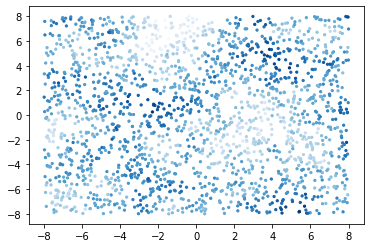

In [3]:
#%%
phi = 0.5
sigma = 1.1
NoS = 2000

n1a,n1b = -8,8
n2a,n2b = -8,8 

x1 = np.linspace(n1a,n1b,NoS)
x2 = np.linspace(n1a,n1b,NoS)

np.random.shuffle(x1)
np.random.shuffle(x2)

X = np.array([x1,x2]).T

cmatrix = sigma**2 * np.exp(-phi * GetD(X,X))
y = np.random.multivariate_normal(mean=np.zeros(NoS), cov=cmatrix)
y = y.reshape(-1,1)


fig = plt.figure()
plt.scatter(X[:,0],X[:,1],c=y,s=5,cmap='Blues')
plt.show()

locs = X

## generate upper layer data 

In [4]:
#%% simulate upper-layer [-8,8], knots0=64
knots0_1 = np.arange(-7,7.1,2)
knots0_2 = np.arange(-7,7.1,2)
knots0 = []
for i in knots0_1:
    for j in knots0_2:
        knots0.append([i,j])
knots0 = np.array(knots0)

distance = dist(locs,knots0)
clas = np.argmin(distance,axis=1)+1

y0 = []
for i in range(clas.min(),clas.max()+1):
    y0.append(np.mean(y[clas==i]))
y0 = np.array(y0).reshape(-1,1)
    

## make structure, and get likelihood

1st -> 2nd
top -> down 
low-res -> high-resolution

summation of all likelihoods from 2nd layer
plus the likelihood of the 1st layer

In [5]:
#%% make structure
# storage
class makeNote():
    def __init__(self):
        self.ID = None
        self.ys = None #
        self.locs = None
        self.locscenter = None
        self.knots = None
        self.N = None
        self.K = None
        self.Kinv = None
        self.B = None
        self.parentID = None
        self.childenID = None
        self.loglike1 = None
        self.loglike2 = None
        self.clas = None # determine the pixel's partition, for each level


phis = [0.5, 0.5]
sigmas = [1.1, 1.1]

phis0,phis1,sigmas0,sigmas1 = 0.5, 0.5, 1.1, 1.1


# res=0
def getloglike(phis0,phis1,sigmas0,sigmas1,y0,y,locs,knots0,clas):
    data = makeNote()
    data.ID = 'root'
    data.yall = y
    data.ys = y0
    data.locs = locs
    data.K = sigmas0**2 * np.exp(-phis0 * GetD(knots0,knots0))
    data.Kinv = np.linalg.inv(data.K)
    data.B = sigmas0**2 * np.exp(-phis0 * GetD(locs,knots0))
    data.childrenID = []
    data.rootindex = {}
    
    for i in range(clas.min(),clas.max()+1):
        new1 = makeNote()
        new1.ID = 'a'+str(i)
        new1.parentID = 'root'
        data.childrenID.append(new1.ID)
        data.rootindex[new1.ID] = new1
        
    
        # new1.locs = data.locs[clas==i]
        new1.locs = data.locs[np.where(clas==i)[0],:]
        new1.ys = data.yall[np.where(clas==i)[0],:]
        new1.K = sigmas1**2 * np.exp(-phis1 * GetD(new1.locs,new1.locs)) # all within this parition are knots
        new1.Kinv = np.linalg.inv(new1.K)
        
        
    for each in data.childrenID:
        note1 = data.rootindex[each]
        
        sgn, logdetK = slogdet(note1.K) # LU decomposition via LAPACK routine
        
        loglike1 = - note1.ys.T * note1.Kinv * note1.ys
        loglike2 = - sgn*logdetK
        loglike = loglike1[0,0] + loglike2
        note1.loglike = loglike
    
    
    sgn, logdetK = slogdet(data.K)
    loglike1 = - data.ys.T * data.Kinv * data.ys
    loglike2 = - sgn*logdetK
    data.loglike = loglike1[0,0] + loglike2
    
    loglikes = []
    for each in data.childrenID:
        loglikes.append(data.rootindex[each].loglike)
    loglikes.append(data.loglike)
    loglike_all = sum(loglikes)
    
    return loglike_all

## Get parameters

In [6]:
#%%  phis,sigmas,y0,locs,knots0,clas
np.random.seed(68)
params = {}

# fine-tuned. True is [0.5, 0.5, 1.1, 1.1]
params['phis0'] = 0.3
params['phis1'] = 0.3
params['sigmas0'] = 1.5
params['sigmas1'] = 1.5


# fixed
params['y0'] = y0
params['locs'] = locs
params['knots0'] = knots0
params['clas'] = clas

def negativeloglikelihood(params):
    l = getloglike(phis0=params[0], sigmas0=params[1], phis1=params[2], sigmas1=params[3],y0=y0,y=y,locs=locs,knots0=knots0,clas=clas)
    print(l, params)
    return -l

xmin = opt.minimize(negativeloglikelihood, [params['phis0'],params['phis1'],params['sigmas0'],params['sigmas1']], bounds=((1e-4, 1e4),(1e-4, 1e4),(1e-4, 1e4),(1e-4, 1e4)), method='L-BFGS-B')
logging.info(str(xmin))
print(xmin)


-873.5304454577106 [0.3 0.3 1.5 1.5]
-873.5304332852277 [0.30000001 0.3        1.5        1.5       ]
-873.530410224367 [0.3        0.30000001 1.5        1.5       ]
-873.5304536217743 [0.3        0.3        1.50000001 1.5       ]
-873.5304655495695 [0.3        0.3        1.5        1.50000001]
-1141760877841383.5 [1.21754829e+03 3.52363436e+03 1.00000000e-04 1.00000000e-04]
-1141760877841383.5 [1.21754829e+03 3.52363436e+03 1.00000000e-04 1.00000000e-04]
-1141760877841383.5 [1.21754829e+03 3.52363436e+03 1.00000000e-04 1.00000000e-04]
-1141646714103153.5 [1.21754829e+03 3.52363436e+03 1.00010000e-04 1.00000000e-04]
-1141532559912746.5 [1.21754829e+03 3.52363436e+03 1.00000000e-04 1.00010000e-04]
-37.2415443493029 [4.06040415e+02 1.17471869e+03 1.00004444e+00 1.00004444e+00]
-37.2415443493029 [4.06040415e+02 1.17471869e+03 1.00004444e+00 1.00004444e+00]
-37.241544350392815 [4.06040415e+02 1.17471869e+03 1.00004444e+00 1.00004444e+00]
-37.241550797659215 [4.06040415e+02 1.17471869e+03 1

-13386399239677.477 [1.00010000e-04 1.00000000e-04 1.00000000e-04 7.33550854e+00]
-13385060729854.04 [1.00000000e-04 1.00010000e-04 1.00000000e-04 7.33550854e+00]
-13387737875788.627 [1.00000000e-04 1.00000000e-04 1.00010000e-04 7.33550854e+00]
-13387737875809.648 [1.00000000e-04 1.00000000e-04 1.00000000e-04 7.33550855e+00]
24.267412146618057 [1.66339921 4.37238767 0.12164464 3.60733641]
24.267412138140287 [1.66339922 4.37238767 0.12164464 3.60733641]
24.267411864405915 [1.66339921 4.37238768 0.12164464 3.60733641]
24.267314833969266 [1.66339921 4.37238767 0.12164465 3.60733641]
24.267405104766226 [1.66339921 4.37238767 0.12164464 3.60733642]
745.9043637553974 [2.44936822 6.43845166 0.17907887 1.84564029]
745.9043637548647 [2.44936823 6.43845166 0.17907887 1.84564029]
745.9043635600462 [2.44936822 6.43845167 0.17907887 1.84564029]
745.9043624455852 [2.44936822 6.43845166 0.17907888 1.84564029]
745.9043627492844 [2.44936822 6.43845166 0.17907887 1.8456403 ]
-578900.6910783537 [1.000000

800.7698087082974 [0.91024439 0.83247383 0.14781058 2.42501289]
800.7698428875334 [0.91024439 0.83247383 0.14781057 2.4250129 ]
863.8648105918427 [0.43535162 0.88796793 0.05387611 3.51870277]
863.8648103784436 [0.43535163 0.88796793 0.05387611 3.51870277]
863.8648103782838 [0.43535162 0.88796794 0.05387611 3.51870277]
863.8647713894668 [0.43535162 0.88796793 0.05387612 3.51870277]
863.864808999351 [0.43535162 0.88796793 0.05387611 3.51870278]
873.5957127261022 [0.39638183 0.89252179 0.04616783 3.60845116]
873.5957125456989 [0.39638184 0.89252179 0.04616783 3.60845116]
873.5957125576128 [0.39638183 0.8925218  0.04616783 3.60845116]
873.5957072111803 [0.39638183 0.89252179 0.04616784 3.60845116]
873.5957122105618 [0.39638183 0.89252179 0.04616783 3.60845117]
-857128868896.17 [8.53512886e-01 8.19797287e-01 1.35001928e-01 1.00000000e-04]
-857128868896.17 [8.53512896e-01 8.19797287e-01 1.35001928e-01 1.00000000e-04]
-857128868896.17 [8.53512886e-01 8.19797297e-01 1.35001928e-01 1.00000000e-

967.0050078993796 [0.07532941 2.00072548 0.21638371 1.5773161 ]
-182246536578.883 [1.00000000e-04 8.98088858e+00 7.06021841e-01 1.00000000e-04]
-182246536578.72333 [1.00010000e-04 8.98088858e+00 7.06021841e-01 1.00000000e-04]
-182246536578.883 [1.00000000e-04 8.98088859e+00 7.06021841e-01 1.00000000e-04]
-182246534455.82208 [1.00000000e-04 8.98088858e+00 7.06021851e-01 1.00000000e-04]
-182210092730.98203 [1.00000000e-04 8.98088858e+00 7.06021841e-01 1.00010000e-04]
817.7811763288368 [0.05025373 4.32737274 0.37959125 1.05159407]
817.7811670568343 [0.05025374 4.32737274 0.37959125 1.05159407]
817.7811760992739 [0.05025373 4.32737275 0.37959125 1.05159407]
817.7811984881456 [0.05025373 4.32737274 0.37959126 1.05159407]
817.7811926386221 [0.05025373 4.32737274 0.37959125 1.05159408]
967.1154087018908 [0.07139017 2.36622772 0.24202263 1.49472834]
967.1154049998952 [0.07139018 2.36622772 0.24202263 1.49472834]
967.1154084478974 [0.07139017 2.36622773 0.24202263 1.49472834]
967.1154180640281 

995.1692790250928 [0.01923218 3.65964143 0.33858909 1.37086206]
995.1692769726554 [0.01923218 3.65964142 0.3385891  1.37086206]
995.1692772215847 [0.01923218 3.65964142 0.33858909 1.37086207]
996.3504969097964 [0.01945912 3.39252796 0.32145583 1.38712206]
996.3504956150142 [0.01945913 3.39252796 0.32145583 1.38712206]
996.3504968854148 [0.01945912 3.39252797 0.32145583 1.38712206]
996.3504961794514 [0.01945912 3.39252796 0.32145584 1.38712206]
996.3504957604432 [0.01945912 3.39252796 0.32145583 1.38712207]
-5073.563633569901 [1.00000000e-04 4.56191852e+00 3.95568543e-01 1.25588435e+00]
-5072.926701124583 [1.00010000e-04 4.56191852e+00 3.95568543e-01 1.25588435e+00]
-5073.563605653712 [1.00000000e-04 4.56191853e+00 3.95568543e-01 1.25588435e+00]
-5073.5636343033975 [1.00000000e-04 4.56191852e+00 3.95568553e-01 1.25588435e+00]
-5073.563634714965 [1.00000000e-04 4.56191852e+00 3.95568543e-01 1.25588436e+00]
998.6230841668341 [0.01303084 3.78082943 0.3460653  1.34354398]
998.6230913264815 

1012.4909579928853 [0.00867766 4.8464567  0.51930145 1.08430436]
1012.490957936657 [0.00867766 4.8464567  0.51930144 1.08430437]
1012.0695039651955 [0.0127417  3.73380109 0.53044283 1.07187963]
1012.0695140203528 [0.01274171 3.73380109 0.53044283 1.07187963]
1012.069504026379 [0.0127417  3.7338011  0.53044283 1.07187963]
1012.0695044263691 [0.0127417  3.73380109 0.53044284 1.07187963]
1012.0695044680708 [0.0127417  3.73380109 0.53044283 1.07187964]
1012.6593062441954 [0.01025351 4.41502084 0.52362155 1.07948663]
1012.6593104794359 [0.01025352 4.41502084 0.52362155 1.07948663]
1012.659306257874 [0.01025351 4.41502085 0.52362155 1.07948663]
1012.6593066640088 [0.01025351 4.41502084 0.52362156 1.07948663]
1012.6593066443496 [0.01025351 4.41502084 0.52362155 1.07948664]
1013.0086606348408 [0.01202278 4.14333324 0.53507874 1.07063668]
1013.0086625373963 [0.01202279 4.14333324 0.53507874 1.07063668]
1013.0086606392254 [0.01202278 4.14333325 0.53507874 1.07063668]
1013.0086608821581 [0.012022

1019.1922225354027 [0.22970546 0.91960033 0.51503346 1.09159504]
1019.1922231046642 [0.22970547 0.91960033 0.51503346 1.09159504]
1019.192222818701 [0.22970546 0.91960034 0.51503346 1.09159504]
1019.192222752397 [0.22970546 0.91960033 0.51503347 1.09159504]
1019.1922226516434 [0.22970546 0.91960033 0.51503346 1.09159505]
1019.8602272193269 [0.19669099 1.04133767 0.52914659 1.07905524]
1019.8602275673927 [0.196691   1.04133767 0.52914659 1.07905524]
1019.8602273016528 [0.19669099 1.04133768 0.52914659 1.07905524]
1019.8602273120517 [0.19669099 1.04133767 0.5291466  1.07905524]
1019.8602273014463 [0.19669099 1.04133767 0.52914659 1.07905525]
1019.473233057915 [0.23905489 0.9546252  0.5352163  1.0909736 ]
1019.4732333321685 [0.2390549 0.9546252 0.5352163 1.0909736]
1019.473233167828 [0.23905489 0.95462521 0.5352163  1.0909736 ]
1019.4732320647399 [0.23905489 0.9546252  0.53521631 1.0909736 ]
1019.4732319789412 [0.23905489 0.9546252  0.5352163  1.09097361]
1020.0186875821373 [0.21152861 1.